#### Manual Strategy Execution
I can use the LSEG refinitiv API for data collection | RUN Refinitiv Workspace in background for {Automatic Authentication} <br> I need to do better data analysis and outlier detection etc for better algo development

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import math
import refinitiv.data as rd
from refinitiv.data.content import fundamental_and_reference
import os
from pprint import pprint
import seaborn as sns
from IPython.display import display
import time
from warnings import filterwarnings
import importlib
filterwarnings('ignore') 

In [2]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

In [3]:
import utils
import utils.methods
import utils.retrieve
importlib.reload(utils.methods)
importlib.reload(utils.retrieve)

<module 'utils.retrieve' from 'c:\\Users\\Alik\\Desktop\\M_year\\MPhil\\Options\\Quant&Finance\\QRT_Acad\\ML_PT\\Research\\utils\\retrieve.py'>

In [4]:
from utils.methods import SelectCointegratedPairs
from utils.retrieve import _call_stocks
from utils.cluster import _agglo_cluster

In [ ]:
print(np.__version__)
print(rd.__version__)

tmp_fields = ["TRDPRC_1", "OPEN_PRC", "HIGH_1", "LOW_1", "ACVOL_UNS"]
benchmark = ['SPY']
start = "2024-01-01"
end = "2024-12-31"
day_limit = 252
variance_perc = 0.9
cluster_distance_threshold = None
cluster_percentile = 20

1.26.4
1.6.2


In [8]:
# api_key = os.environ("LSEG_API_KEY")
# rd.open_session(app_key=api_key)
rd.open_session()

<refinitiv.data.session.Definition object at 0x21af51ef0b0 {name='workspace'}>

##### Universe Retrieval

In [10]:
stocks = _call_stocks(limit=50, is_nasdaq = True)
print(stocks[:10])

print('Stocks: ', len(stocks))

# stocks = universe_creation()

 ---> Number of Sampled Stocks:  18
['POOL.OQ', 'CHRW.OQ', 'FOX.OQ', 'HBAN.OQ', 'ON.OQ', 'EVRG.OQ', 'SMCI.OQ', 'COST.OQ', 'LULU.OQ', 'PAYX.OQ']
Stocks:  18


In [15]:
### Snapshots for Pricing
df = rd.get_data(
    universe=stocks,
    fields=tmp_fields,
    parameters={"SDate": start, "EDate": end, "Frq": "D", "Curn":"USD"}
)

display(df.head(5))
print()

,Instrument,TRDPRC_1,OPEN_PRC,HIGH_1,LOW_1,ACVOL_UNS
0,POOL.OQ,<NA>,<NA>,<NA>,<NA>,69
1,CHRW.OQ,<NA>,<NA>,<NA>,<NA>,10
2,FOX.OQ,<NA>,<NA>,<NA>,<NA>,248
3,HBAN.OQ,<NA>,<NA>,<NA>,<NA>,<NA>
4,ON.OQ,<NA>,<NA>,<NA>,<NA>,498


##### LSEG .get_history() information - A FY has 252 trading days
<br>

| Column Name  | Description  |
|-------------|--------------|
| **TRDPRC_1** | Last traded price (closing price for that period). |
| **HIGH_1** | Highest price reached during the time period. |
| **LOW_1** | Lowest price reached during the time period. |
| **ACVOL_UNS** | Accumulated volume of trades (unscaled). |
| **OPEN_PRC** | Opening price of the asset for that period. |
| **BID** | Last recorded bid price (highest price a buyer is willing to pay). |
| **ASK** | Last recorded ask price (lowest price a seller is willing to accept). |
| **TRNOVR_UNS** | Turnover (traded value) in unscaled units. |
| **VWAP** | **Volume Weighted Average Price** - average trading price considering volume. |
| **BLKCOUNT** | Number of block trades (large transactions executed outside regular markets). |
| **BLKVOLUM** | Volume of shares traded in block trades. |
| **NUM_MOVES** | Number of price movements during the period. |
| **TRD_STATUS** | Trading status (e.g., open, closed, halted, auction, etc.). |
| **SALTIM** | Time of the last trade in seconds from midnight. |
| **CLS_AUCVOL** | Volume traded during the **closing auction**. |
| **OPN_AUCVOL** | Volume traded during the **opening auction**. |
| **VWAP_VOL** | Volume used to calculate VWAP (if different from ACVOL_UNS). |


In [ ]:
ft = time.time()
df_uni10 = rd.get_history(universe=stocks, fields=tmp_fields, interval="1D", start = start, end = end).dropna()
lt = time.time()

print('retrieval-time: ', (lt - ft) / 60, 'mins')

display(df_uni10.head(5))

print(df_uni10.shape)

for nm in stocks:
    print('NAME:', nm)
    display(df_uni10[nm].head(2))
    break

retrieval-time:  0.16989599466323851 mins


POOL.OQ                            ...  TECH.OQ                        
           TRDPRC_1 OPEN_PRC  HIGH_1    LOW_1  ... OPEN_PRC HIGH_1  LOW_1 ACVOL_UNS
Date                                           ...                                 
2024-01-02   388.15   394.26  397.91  385.875  ...    76.38  77.87  75.84    383635
2024-01-03   373.78   382.87  383.02   373.43  ...    76.48  76.51  71.85    464119
2024-01-04   372.87   370.33  376.59   370.33  ...    72.14  72.45  71.72    607913
2024-01-05   377.73    371.6   379.5    371.6  ...    71.96  72.77  71.05    386416
2024-01-08   381.44   374.63  382.21   374.63  ...    71.19  73.24  70.49    329670

[5 rows x 90 columns]

(252, 90)
NAME: POOL.OQ


,TRDPRC_1,OPEN_PRC,HIGH_1,LOW_1,ACVOL_UNS
Date,,,,,
2024-01-02,388.15,394.26,397.91,385.875,133606
2024-01-03,373.78,382.87,383.02,373.43,120446


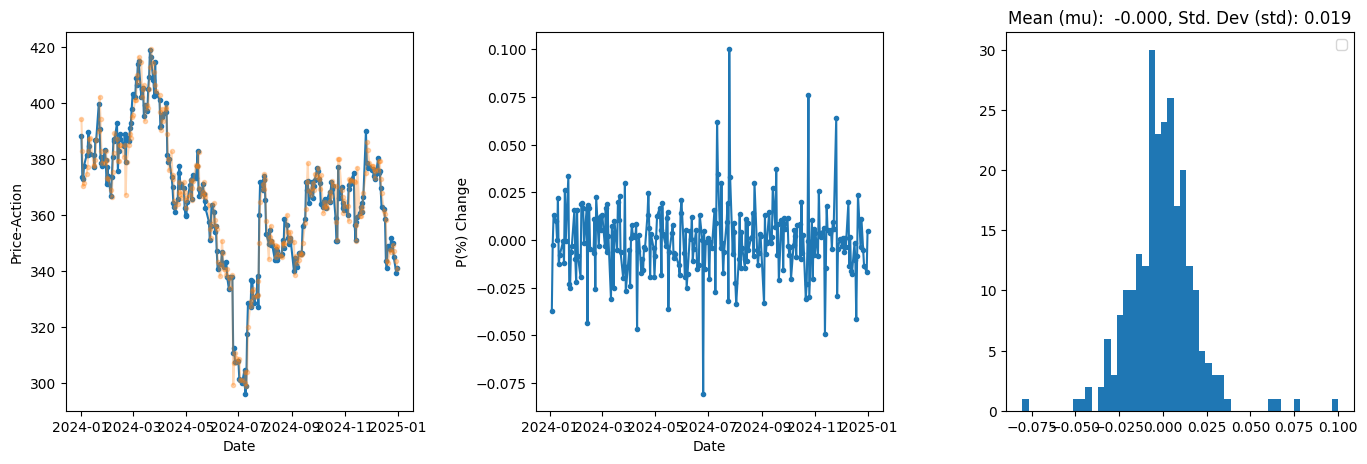

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(14, 5))

### We just do multi-indexing
axs[0].plot(df_uni10.index, df_uni10[stocks[0]]['TRDPRC_1'], marker = '.', label='close')
axs[0].plot(df_uni10.index, df_uni10[stocks[0]]['OPEN_PRC'], marker = '.', label='open', alpha=0.3)
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Price-Action')

axs[1].plot(df_uni10.index, df_uni10[stocks[0]]['TRDPRC_1'].pct_change(), marker = '.', label='close')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('P(%) Change')

axs[2].hist(df_uni10[stocks[0]]['TRDPRC_1'].pct_change(), bins = 50)
_mu = df_uni10[stocks[0]]['TRDPRC_1'].pct_change().mean()
_std = df_uni10[stocks[0]]['TRDPRC_1'].pct_change().std()
axs[2].set_title(f'Mean (mu):  {_mu:.3f}, Std. Dev (std): {_std:.3f}')

plt.tight_layout(pad = 2)
plt.legend()
plt.show()

In [18]:
print('LEN: ', len(stocks))

LEN:  18


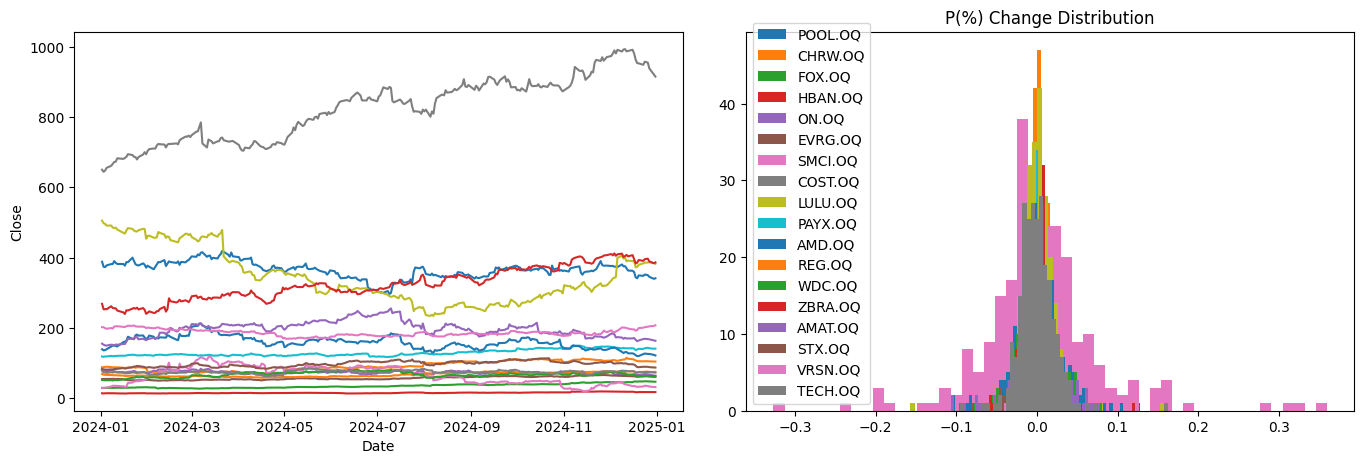

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

### We just do multi-indexing
for nm in stocks:
    axs[0].plot(df_uni10.index, df_uni10[nm]['TRDPRC_1'], label = nm)
    axs[0].set_xlabel('Date')
    axs[0].set_ylabel('Close')

plt.legend()

for nm in stocks:

    pct_change_clean = df_uni10[nm]['TRDPRC_1'].pct_change().dropna()

    if pct_change_clean.empty:
        print(f"Skipping {nm} due to no valid percentage change data.")
        continue
    
    axs[1].hist(pct_change_clean, bins = 50, label = nm)
    axs[1].set_title(f'P(%) Change Distribution')

plt.tight_layout(pad = 2)
plt.legend()
plt.show()

In [39]:
fundamental_df = rd.get_data(
    universe=stocks,
    fields=["TR.Revenue.date", "TR.Revenue", "TR.GrossProfit"],
    parameters={
        "SDate": start,
        "EDate": end, # Full fiscal year
        "FRQ": "D", # Fiscal Year frequency (more standard than "A")
        "Curn": "USD" # Currency normalization
    }
)

display(fundamental_df.head(5))
print(fundamental_df.shape)
print(fundamental_df.columns)

## creates multi-index based on column indexing
fundamental_df = fundamental_df.set_index(['Instrument', 'Date'])

display(fundamental_df.head(5))
print(fundamental_df.shape)

display(fundamental_df.loc[stocks[0]].head(5))
print(fundamental_df.loc[stocks[0]].shape)

,Instrument,Date,Revenue,Gross Profit
0,POOL.OQ,2022-12-31,6179727000,1933412000
1,POOL.OQ,2022-12-31,6179727000,1933412000
2,POOL.OQ,2022-12-31,6179727000,1933412000
3,POOL.OQ,2022-12-31,6179727000,1933412000
4,POOL.OQ,2022-12-31,6179727000,1933412000


(4034, 4)
Index(['Instrument', 'Date', 'Revenue', 'Gross Profit'], dtype='object')


Revenue  Gross Profit
Instrument Date                                
POOL.OQ    2022-12-31  6179727000    1933412000
           2022-12-31  6179727000    1933412000
           2022-12-31  6179727000    1933412000
           2022-12-31  6179727000    1933412000
           2022-12-31  6179727000    1933412000

(4034, 2)


,Revenue,Gross Profit
Date,,
2022-12-31,6179727000,1933412000
2022-12-31,6179727000,1933412000
2022-12-31,6179727000,1933412000
2022-12-31,6179727000,1933412000
2022-12-31,6179727000,1933412000


(252, 2)


['2022-12-31T00:00:00.000000000' '2023-12-31T00:00:00.000000000']


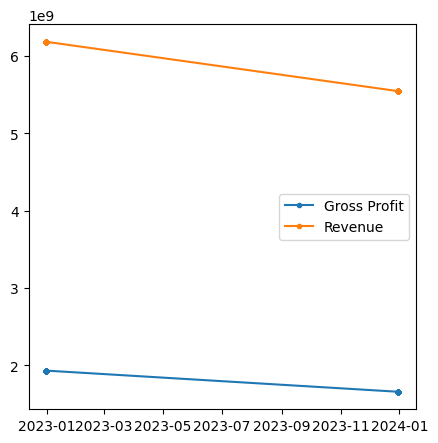

In [21]:
fig = plt.figure(figsize=(5, 5))

print(np.unique(np.array(fundamental_df.loc[stocks[0]].index))) ### Maybe thats the time when gross-profit and revenue gets published (but shouldn't that be q1-4) - annual report for 1FY not quartly 
plt.plot(fundamental_df.loc[stocks[0]].index, fundamental_df.loc[stocks[0]]['Gross Profit'], marker = '.', label = 'Gross Profit')
plt.plot(fundamental_df.loc[stocks[0]].index, fundamental_df.loc[stocks[0]]['Revenue'], marker = '.', label = 'Revenue')

plt.legend()
plt.show()

In [53]:
val_arr = []
_elem_stocks = []

for i, nm in enumerate(stocks):
    pct = np.array(df_uni10[nm]['TRDPRC_1'].pct_change().fillna(0)).tolist()
    close = np.array(df_uni10[nm]['TRDPRC_1']).tolist()
    vol = np.array(df_uni10[nm]['ACVOL_UNS']).tolist()
    revenue = np.array(fundamental_df.loc[nm]['Revenue']).tolist() 
    gross_profit = np.array(fundamental_df.loc[nm]['Gross Profit']).tolist()

    # was = np.array(fundamental_df.loc[nm]['Basic Weighted Average Shares'])

    if (len(revenue) == 1) or (len(gross_profit) == 1):
        _elem_stocks.append(nm)
        continue

    val_arr.append([close, pct, vol, revenue, gross_profit])
    
print(len(val_arr), len(val_arr[0]))
val_arr = np.array(val_arr)
print(val_arr.shape)

stocks = [_s for _s in stocks if _s not in _elem_stocks]
print('New-Stocks: ', stocks)
print(len(stocks))

val_arr = val_arr.reshape(len(stocks), -1)
print(val_arr.shape)



16 5
(16, 5, 252)
New-Stocks:  ['POOL.OQ', 'CHRW.OQ', 'FOX.OQ', 'ON.OQ', 'SMCI.OQ', 'COST.OQ', 'LULU.OQ', 'PAYX.OQ', 'AMD.OQ', 'REG.OQ', 'WDC.OQ', 'ZBRA.OQ', 'AMAT.OQ', 'STX.OQ', 'VRSN.OQ', 'TECH.OQ']
16
(16, 1260)


##### PCA + Clustering
A fixed n_components shows systemic risk/volatility which shows fewer components moving the market while unsystemic risk shows diversification and more singular stock trading oppurtunity  

(16, 5)


<Figure size 500x500 with 0 Axes>

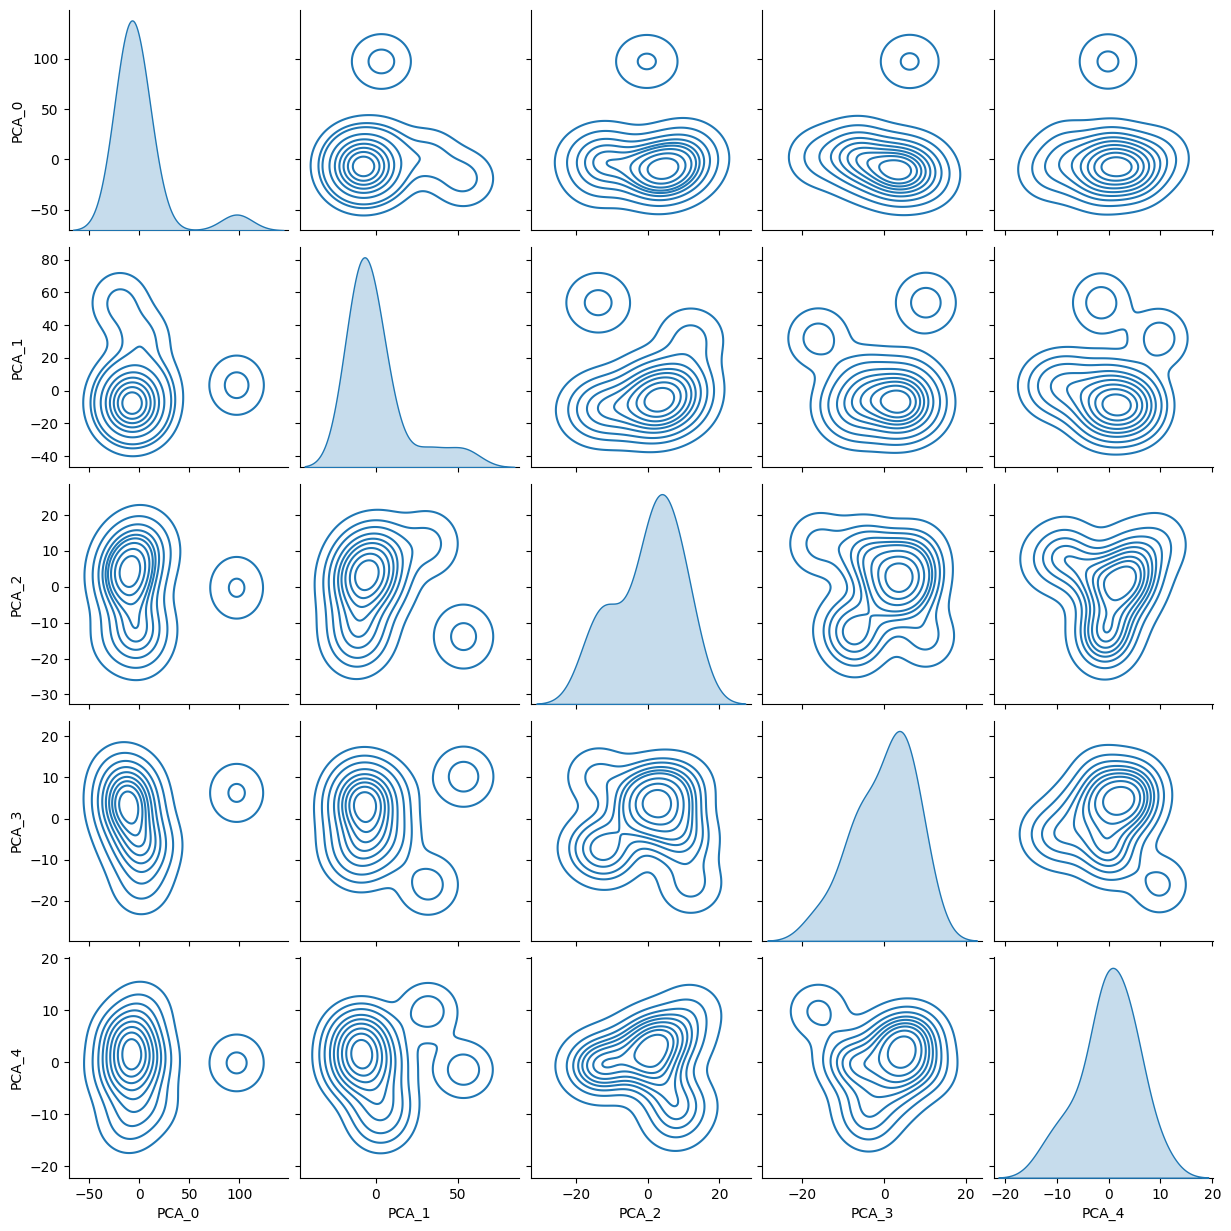

In [54]:
scaler = StandardScaler()
scaled_arr = scaler.fit_transform(val_arr)

pca = PCA(n_components=variance_perc)
pca_arr = pca.fit_transform(scaled_arr)

print(pca_arr.shape)

fig = plt.figure(figsize=(5, 5))

sns.pairplot(pd.DataFrame(pca_arr, columns=['PCA_' + str(i) for i in range(pca_arr.shape[-1])]), kind='kde')
plt.show()

In [ ]:
cluster_labels = _agglo_cluster(pca_arr)
print('Number of Clusters: ', len(np.unique(cluster_labels)))

Number of Clusters:  7


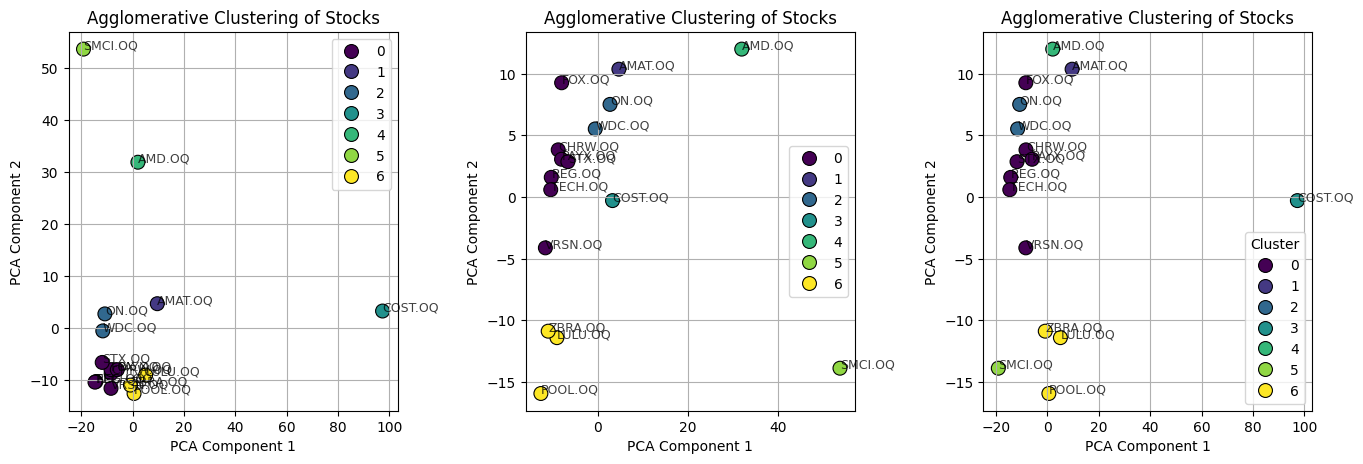

In [57]:
fig, axs = plt.subplots(1, 3, figsize=(14, 5))

sns.scatterplot(x=pca_arr[:, 0], y=pca_arr[:, 1], hue=cluster_labels, palette="viridis", s=100, edgecolor="black", ax = axs[0])
sns.scatterplot(x=pca_arr[:, 1], y=pca_arr[:, 2], hue=cluster_labels, palette="viridis", s=100, edgecolor="black", ax = axs[1])
sns.scatterplot(x=pca_arr[:, 0], y=pca_arr[:, 2], hue=cluster_labels, palette="viridis", s=100, edgecolor="black", ax = axs[2])

for i, stock in enumerate(stocks):
    axs[0].annotate(stock, (pca_arr[i, 0], pca_arr[i, 1]), fontsize=9, alpha=0.75)

for i, stock in enumerate(stocks):
    axs[1].annotate(stock, (pca_arr[i, 1], pca_arr[i, 2]), fontsize=9, alpha=0.75)

for i, stock in enumerate(stocks):
    axs[2].annotate(stock, (pca_arr[i, 0], pca_arr[i, 2]), fontsize=9, alpha=0.75)


axs[0].set_title("Agglomerative Clustering of Stocks")
axs[0].set_xlabel("PCA Component 1")
axs[0].set_ylabel("PCA Component 2")

axs[1].set_title("Agglomerative Clustering of Stocks")
axs[1].set_xlabel("PCA Component 1")
axs[1].set_ylabel("PCA Component 2")

axs[2].set_title("Agglomerative Clustering of Stocks")
axs[2].set_xlabel("PCA Component 1")
axs[2].set_ylabel("PCA Component 2")

axs[0].grid()
axs[1].grid()
axs[2].grid()

plt.legend(title="Cluster")
plt.tight_layout(pad=2)
plt.show()

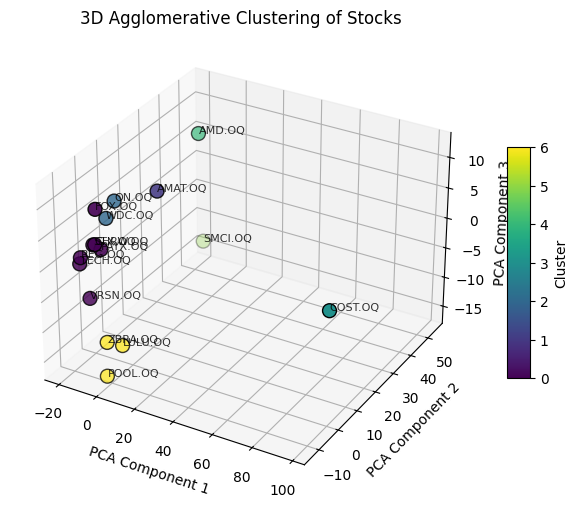

In [58]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(pca_arr[:, 0], pca_arr[:, 1], pca_arr[:, 2], 
                c=cluster_labels, cmap="viridis", s=100, edgecolor="black")

for i, stock in enumerate(stocks):
    ax.text(pca_arr[i, 0], pca_arr[i, 1], pca_arr[i, 2], stock, fontsize=8, alpha=0.8)

ax.set_title("3D Agglomerative Clustering of Stocks")
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")

cbar = plt.colorbar(sc, ax=ax, shrink=0.5, aspect=10)
cbar.set_label("Cluster")

plt.show()

#### Co-Integration Selection + Volatility Weighted Portofolio Creation  

In [ ]:
from utils.methods import SelectCointegratedPairs
from utils.methods import FilterHighCorrelationPairs  

print('Manual-Stock-Universe: ', ', '.join(stocks))

Manual-Stock-Universe:  POOL.OQ, CHRW.OQ, FOX.OQ, ON.OQ, SMCI.OQ, COST.OQ, LULU.OQ, PAYX.OQ, AMD.OQ, REG.OQ, WDC.OQ, ZBRA.OQ, AMAT.OQ, STX.OQ, VRSN.OQ, TECH.OQ


In [67]:
pairs = SelectCointegratedPairs(symbols=stocks, cluster_labels=cluster_labels, history=df_uni10)

print('Number of Pairs Found: ', len(pairs.keys()))

 ---- Clusters ---- 

{6: ['POOL.OQ', 'LULU.OQ', 'ZBRA.OQ'], 0: ['CHRW.OQ', 'FOX.OQ', 'PAYX.OQ', 'REG.OQ', 'STX.OQ', 'VRSN.OQ', 'TECH.OQ'], 2: ['ON.OQ', 'WDC.OQ'], 5: ['SMCI.OQ'], 3: ['COST.OQ'], 4: ['AMD.OQ'], 1: ['AMAT.OQ']}

 ------------- 
Testing cointegration in cluster 6 with 3 symbols.
Testing cointegration in cluster 0 with 7 symbols.
Cointegrated pair found: CHRW.OQ_REG.OQ with p-value 0.03379384397079591 and Hurst -0.07
Testing cointegration in cluster 2 with 2 symbols.
Cointegrated pair found: ON.OQ_WDC.OQ with p-value 0.03642324584968369 and Hurst -0.00
Number of Pairs Found:  2


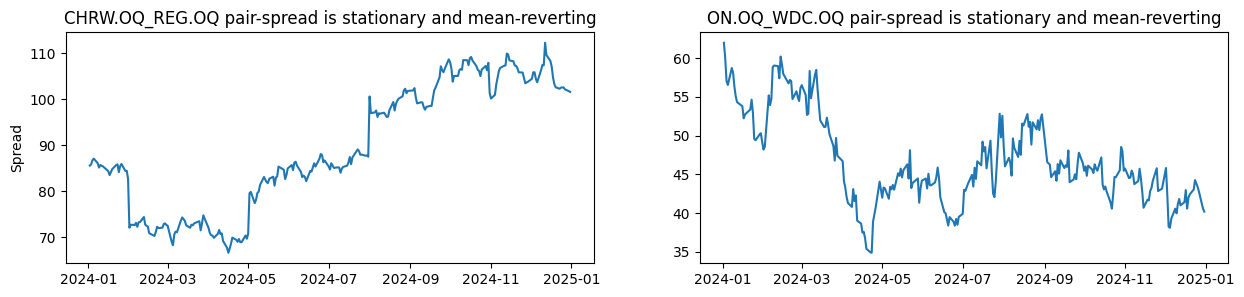

In [75]:
fig, axs = plt.subplots(1, 2, figsize=(15, 3))

axs[0].plot(pairs[list(pairs.keys())[0]]['spread_series'])
axs[0].set_title(f'{list(pairs.keys())[0]} pair-spread is stationary and mean-reverting')
axs[0].set_ylabel('Spread')

axs[1].plot(pairs[list(pairs.keys())[-1]]['spread_series'])
axs[1].set_title(f'{list(pairs.keys())[-1]} pair-spread is stationary and mean-reverting')

plt.show()

In [ ]:
pairs = FilterHighCorrelationPairs(pairs)
print(f"Number of pairs after correlation filtering: {len(pairs)}")

if not pairs:
    print("All pairs were filtered out due to high correlation.")

##### Portfolio Construction and Position Sizing based on Constructed Pairs (with inverse-volatility positioning) 

##### Load S&P500 Benchmark

In [ ]:
from utils.position import CalculateMarketVolatility, ManagePosition

In [ ]:
ft = time.time()
df_benchmark = rd.get_history(universe=benchmark, fields=tmp_fields, interval="1D", start = start, end = end).dropna()
lt = time.time()

display(df_benchmark.head(5))

SPY,TRDPRC_1,OPEN_PRC,HIGH_1,LOW_1,ACVOL_UNS
Date,,,,,
2024-01-02,472.65,472.16,473.67,470.49,123007793
2024-01-03,468.79,470.43,471.19,468.17,103585866
2024-01-04,467.28,468.3,470.96,467.05,84232169
2024-01-05,467.92,467.49,470.44,466.43,86118913
2024-01-08,474.6,468.43,474.75,468.3,74879074


In [13]:
benchmark_vol = CalculateMarketVolatility(df_benchmark)
print('SPY-index Volatiliy: ', benchmark_vol)

SPY-index Volatiliy:  0.00842975592988464


In [ ]:
# Liquidate positions not in new pairs
ManagePosition.LiquidatePositionsNotInPairs(pairs)

current_position = ManagePosition.create_position(pairs)

print('Current_Positioning ...')
pprint(current_position)

#### Maybe I need to chuck out a portfolio dataframe with dynamic sizing and weighting first - Maybe need to do it differently
Keep everything -> portfolio creation, export and portfolio backtesting LOCAL 

#### Backtest

In [73]:
import utils 
import utils.backtest
importlib.reload(utils.backtest)
from utils.backtest import Backtest, simple_sma_strategy

In [ ]:
test_stock = stocks[0]
print('test_stock: ', test_stock)

test_stock:  POOL.OQ


POOL.OQ,TRDPRC_1,OPEN_PRC,HIGH_1,LOW_1,ACVOL_UNS
Date,,,,,
2020-01-02,213.81,212.24,213.88,210.34,58656
2020-01-03,215.04,212.65,215.67,212.04,71042
2020-01-06,215.08,214.81,215.34,212.18,57866
2020-01-07,213.02,213.43,214.51,212.96,111786
2020-01-08,214.1,213.53,215.27,213.38,105380


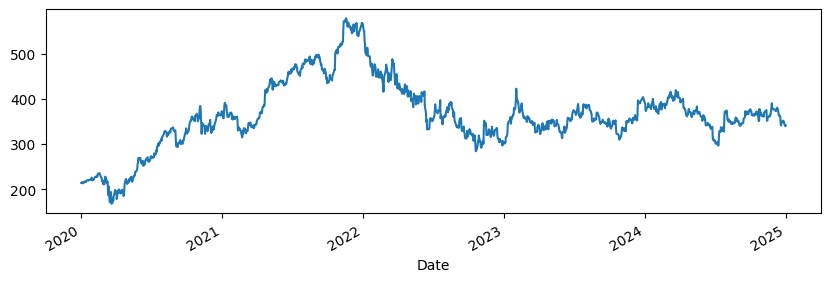

retrieval-time:  0.06206964254379273 mins


In [75]:
ft = time.time()
df_test_data = rd.get_history(universe=test_stock, fields=tmp_fields, interval="1D", start = hist_start_time, end = hist_end_time).dropna()
lt = time.time()

display(df_test_data.head(5))

plt.figure(figsize=(10, 3))

df_test_data['TRDPRC_1'].plot()
plt.show()

print('retrieval-time: ', (lt - ft) / 60, 'mins')


{'Total Return': '2.75%', 'Sharpe Ratio': '0.14', 'Max Drawdown': '-39.00%'}


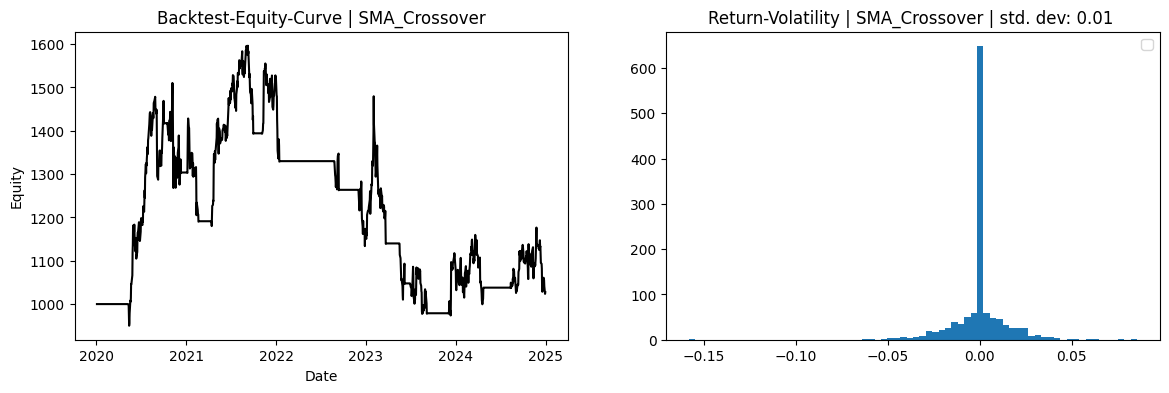

In [76]:
# Run backtest
backtest = Backtest(df_test_data, simple_sma_strategy, name='SMA_Crossover')
backtest.run()

# Print performance
print(backtest.performance())

# Plot equity curve
backtest.plot()

My first goal should be to complete the basic pipeline before tuning the actual algorithm. This includes an end-to-end implementation, from stock selection to sending hedged portfolios to the QRT FTP servers for the daily report.

### Data Presence Matrix OR Stock Presence Matrix (in Universe)

In [ ]:
sd.close_session()